# 1. Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sb
sb.set()

import re
import torch
import transformers
from tqdm import notebook

import spacy

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm, tqdm_notebook, notebook

from pymystem3 import Mystem

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin


from catboost import Pool, CatBoostClassifier

In [2]:
df = pd.read_csv('toxic_comments.csv')

In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<AxesSubplot:>

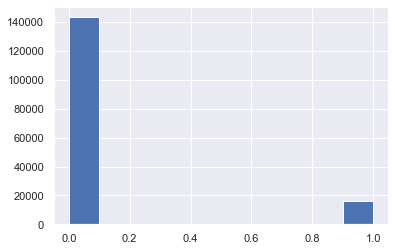

In [4]:
df['toxic'].hist()

Виден явный дисбаланс классов  
Так же данные имеют мусорные символы, от которых нужно избавиться

### Проведем очищение текста

In [6]:
def clear_text(text):
    
    text = text.lower()    
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", " ", text).split()
    
    return ' '.join(text)

In [7]:
nlp = spacy.load("en_core_web_sm")

In [8]:
df['clean_text'] = df['text'].apply(lambda x: clear_text(x))

In [9]:
df.head()

,text,toxic,clean_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


### Лемматизация

In [10]:
def lemm(text):
    lem = [token.lemma_ for token in nlp(text)]
    # Стоп-слова библиотека помечает как -PRON-, избавимся от них
    while '-PRON-' in lem:
        lem.remove('-PRON-')
    return ' '.join(lem)

In [11]:
tqdm.pandas()
df['lemm_text'] = df['clean_text'].progress_apply(lemm)

100%|██████████████████████████████████████████████████████████████████████████| 159571/159571 [40:39<00:00, 65.42it/s]


Т.к. процедура выполняется долго - сохрами результат в отдельный файл

In [12]:
df.to_csv('new_df_last_project_1')

In [13]:
df = pd.read_csv('new_df_last_project_1', index_col=[0])

In [14]:
df.head()

,text,toxic,clean_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under username h...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww match this background colour i m seeming...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war s just ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir be hero any chance remember what page that...


Создадим новый датасет с дополнительными признаками и посмотрим на них
1. Количество слов в тексте
2. Количество уникальных слов
3. Кол-во стоп-слов
4. Средняя длина слова

In [15]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def new_features(data, stop_words):
    data['words_count_in_text'] = data['text'].apply(lambda x: len(x.split()))
    data['unique_count'] = data['text'].apply(lambda x: len(set(x.split())))
    data['stop_words_count'] = data['text'].apply(lambda x: len([w for w in str(x).split() if w in stop_words]))
    data['mean_len_word'] = data['text'].apply(lambda x: np.mean([len(w) for w in x.split()]))

In [17]:
new_features(df,stop_words)

In [18]:
df.head()

,text,toxic,clean_text,lemm_text,words_count_in_text,unique_count,stop_words_count,mean_len_word
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under username h...,43,41,14,5.162791
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww match this background colour i m seeming...,17,17,1,5.588235
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war s just ...,42,39,18,4.571429
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...,113,82,49,4.486726
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,sir be hero any chance remember what page that...,13,13,4,4.230769


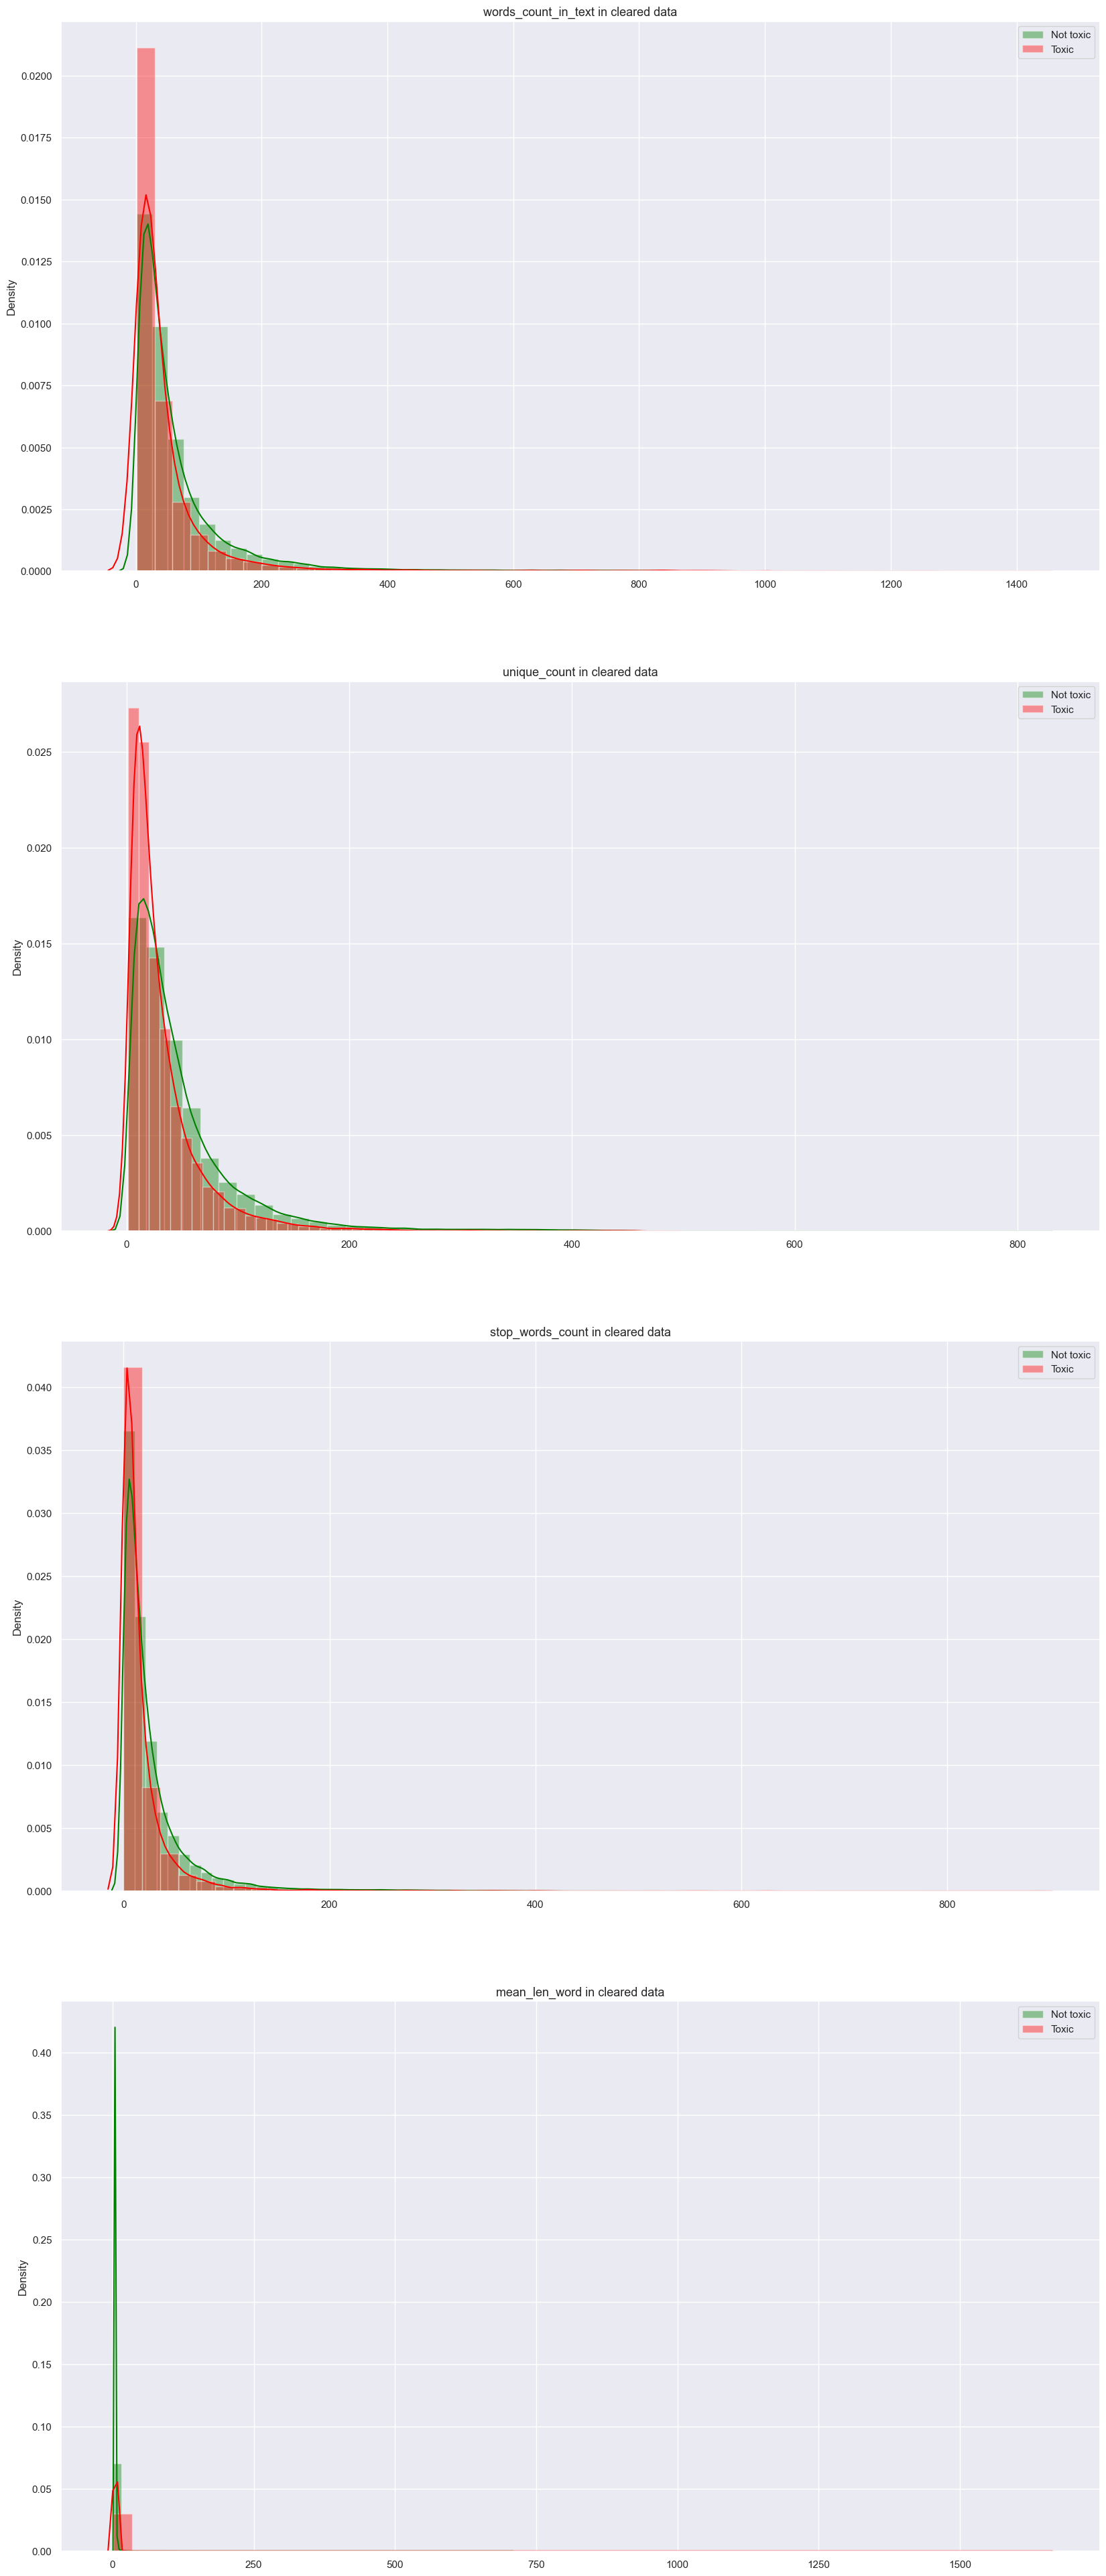

In [19]:

new_features = ['words_count_in_text', 'unique_count', 'stop_words_count', 'mean_len_word']
toxic_comments = df['toxic'] == 1

fig, axes = plt.subplots(ncols=1, nrows=len(new_features), figsize=(20, 50), dpi=100)

for i, feature in enumerate(new_features):
    sb.distplot(df.loc[~toxic_comments][feature], label='Not toxic', ax=axes[i], color='green')
    sb.distplot(df.loc[toxic_comments][feature], label='Toxic', ax=axes[i], color='red')

    axes[i].set_xlabel('')
    axes[i].legend()

    axes[i].set_title(f'{feature} in cleared data', fontsize=13)
    
plt.show()

Как видно из графиков:  
Токсичные комментарии имеют меньше уникальных слов, более короткие и сами слова в них короче

# 2. Обучение

Разделим данные на train, valid и test 

In [20]:
df['clean_text'] = df['clean_text'].values.astype('U')
df['lemm_text'] = df['lemm_text'].values.astype('U')
X = df.drop('toxic', axis=1)
y = df['toxic']

X_train, X_valid, y_train, y_valid = train_test_split(X, y,shuffle=True,test_size=0.2,random_state=12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,shuffle=True,test_size=0.5,random_state=12345)
print('Train_valid shapes:')
print(X_train.shape, y_train.shape)
print('Valid shapes:')
print(X_valid.shape, y_valid.shape)
print('Test shapes:')
print(X_test.shape, y_test.shape)

Train_valid shapes:
(127656, 7) (127656,)
Valid shapes:
(15957, 7) (15957,)
Test shapes:
(15958, 7) (15958,)


Обучим лог.регрессию на очещенном тексте и лемматизированном

In [21]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=12345))])

In [22]:
for col in ['clean_text', 'lemm_text']:
    pipe.fit(X_train[col], y_train);
    y_valid_pred = pipe.predict(X_valid[col])
    f1 = f1_score(y_valid, y_valid_pred)
    print('F1 for', col, 'is', f1)

F1 for clean_text is 0.7489952502740226
F1 for lemm_text is 0.7460608281421766


Результаты практически одинаковые, при этом на очищенном тексте без лемматизации даже выше немного

Добавим созданные нами фичи

In [23]:
from scipy.sparse import hstack
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
X_train_valid_left = vectorizer.fit_transform(X_train['clean_text'])
X_valid_left = vectorizer.transform(X_valid['clean_text'])

scaler = StandardScaler()
X_train_valid_right = scaler.fit_transform(X_train[new_features])
X_valid_right = scaler.transform(X_valid[new_features])

X_train_valid_vec = hstack((X_train_valid_left, X_train_valid_right))
X_valid_vec = hstack((X_valid_left, X_valid_right))

In [24]:
logit = LogisticRegression(random_state=12345, solver='liblinear', max_iter=500)

logit.fit(X_train_valid_vec, y_train);
y_valid_pred = logit.predict(X_valid_vec)
f1_score(y_valid, y_valid_pred)

0.7486318861729295

Качество недостаточно высокое, попробуем поиск по сетке

In [25]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=12345, solver='liblinear', max_iter=500))
    ])

params = [
        {
            'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
            'model': [LogisticRegression(random_state=12345, solver='liblinear')],
            'model__C': [1, 10, 50, 100, 200]
        }
]

In [26]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=12345)

grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=cv, verbose=False)

In [27]:
%%time
grid.fit(X_train['clean_text'], y_train)

Wall time: 17min 28s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12345, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                       

In [28]:
grid.best_params_, grid.best_score_

({'model': LogisticRegression(C=200, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=12345, solver='liblinear', tol=0.0001,
                     verbose=0, warm_start=False),
  'model__C': 200,
  'vectorizer__ngram_range': (1, 2)},
 0.7792102828389723)

In [29]:
model = grid.best_estimator_

model.fit(X_train['clean_text'], y_train)

y_valid_pred = model.predict(X_valid['clean_text'])

In [30]:
f1_log = f1_score(y_valid, y_valid_pred)
f1_log

0.7875927174645988

Создадим словарь для дальнейшего сравнения

In [31]:
scores = {}
scores['LogReg_Valid'] = f1_log

Качество сильно улучшилось, но дополнительно попробуем catboost.

In [32]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', CatBoostClassifier(random_seed=12345))])

In [33]:
learn_pool = Pool(
    X_train[new_features+['lemm_text']], 
    y_train, 
    text_features=['lemm_text'],
)
test_pool = Pool(
    X_valid[new_features+['lemm_text']], 
    y_valid,
    text_features=['lemm_text'],
)

ctb = CatBoostClassifier(iterations=1000,
                         random_seed=12345,
                         eval_metric='F1')

In [34]:
ctb.fit(learn_pool, eval_set=test_pool, verbose=100)

Learning rate set to 0.104979
0:	learn: 0.7122357	test: 0.7346939	best: 0.7346939 (0)	total: 303ms	remaining: 5m 2s
100:	learn: 0.7611779	test: 0.7669173	best: 0.7669173 (100)	total: 17s	remaining: 2m 31s
200:	learn: 0.7830533	test: 0.7760081	best: 0.7771003 (187)	total: 33.6s	remaining: 2m 13s
300:	learn: 0.7941617	test: 0.7762001	best: 0.7780785 (246)	total: 49.5s	remaining: 1m 54s
400:	learn: 0.8050164	test: 0.7780027	best: 0.7795808 (363)	total: 1m 5s	remaining: 1m 38s
500:	learn: 0.8125240	test: 0.7792732	best: 0.7799124 (448)	total: 1m 22s	remaining: 1m 22s
600:	learn: 0.8194214	test: 0.7800941	best: 0.7800941 (516)	total: 1m 38s	remaining: 1m 5s
700:	learn: 0.8244676	test: 0.7795699	best: 0.7813235 (670)	total: 1m 53s	remaining: 48.5s
800:	learn: 0.8305687	test: 0.7809140	best: 0.7817327 (735)	total: 2m 9s	remaining: 32.2s
900:	learn: 0.8351992	test: 0.7811245	best: 0.7817327 (735)	total: 2m 24s	remaining: 15.9s
999:	learn: 0.8391614	test: 0.7824043	best: 0.7838926 (958)	total: 

In [35]:
scores['CatBoost_Valid'] = ctb.get_best_score()['validation']['F1']

In [36]:
scores

{'LogReg_Valid': 0.7875927174645988, 'CatBoost_Valid': 0.7838926174496645}

In [37]:
pd.DataFrame(scores, index=['F1_score'])

,LogReg_Valid,CatBoost_Valid
F1_score,0.787593,0.783893


Достигнуто практически одинаковое качество у лог.регрессии и у catboost.  
При этом скорость обучения и качество на валидации у лог.регрессии выше.  
Протестируем обе модели на тестовой выборке

## Тестирование

In [38]:
y_pred_test = ctb.predict(X_test[new_features+['lemm_text']])

f1_score(y_test, y_pred_test)

0.782310593075077

In [39]:
y_pred_test = model.predict(X_test['lemm_text'])

f1_score(y_test, y_pred_test)

0.7617315387413605

# 3. Выводы

Лучший результат показал catboost. При этом разница не сильно большая между лемматизированным тесктом и очищенным, но лемматизация занимает примерно 40 минут с учётом применения специальных библиотек для ускорения pandas. Стандартными средствами это длилось бы порядка 40 часов